# **Volatility Forecasting Using GARCH Models**

This project focuses on forecasting financial market volatility using **GARCH (Generalized AutoRegressive Conditional Heteroskedasticity)** models. Unlike simple historical volatility estimates that assume constant variance, GARCH models capture **volatility clustering** — the empirical observation that large price changes tend to be followed by large changes, and small changes by small ones.

---

## **Project Objectives**

* **Analyze and visualize volatility clustering** in financial return series.
* **Fit GARCH-family models** (GARCH(1,1) as a baseline) to historical return data.
* **Forecast future volatility** and evaluate model performance.
* **Discuss practical applications**, including risk management and options pricing.

---

## **Approach Overview**

1. **Data Collection:** Download daily price data for S\&P 500 index (or similar) from `yfinance` and compute log returns.
2. **Exploratory Data Analysis (EDA):** Plot returns, rolling volatility, and autocorrelation of squared returns to identify volatility clustering.
3. **Model Fitting:** Use the `arch` package in Python to fit a GARCH(1,1) model.
4. **Volatility Forecasting:** Generate 1-step-ahead and multi-step volatility forecasts.
5. **Evaluation:** Compare forecasted volatility to realized volatility and plot confidence intervals.

---

## **Data Collection**

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from arch import arch_model
from sklearn.metrics import mean_squared_error
import numpy as np

In [2]:
# Download daily price data for S&P 500 (symbol: ^GSPC)
ticker = "^GSPC"
data = yf.download(ticker, start="2015-01-01", end="2025-01-01", auto_adjust=True)
data = data[['Close']].rename(columns={'Close': 'price'})

# Compute daily log returns 
data['log_return'] = np.log(data['price'] / data['price'].shift(1))
data.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


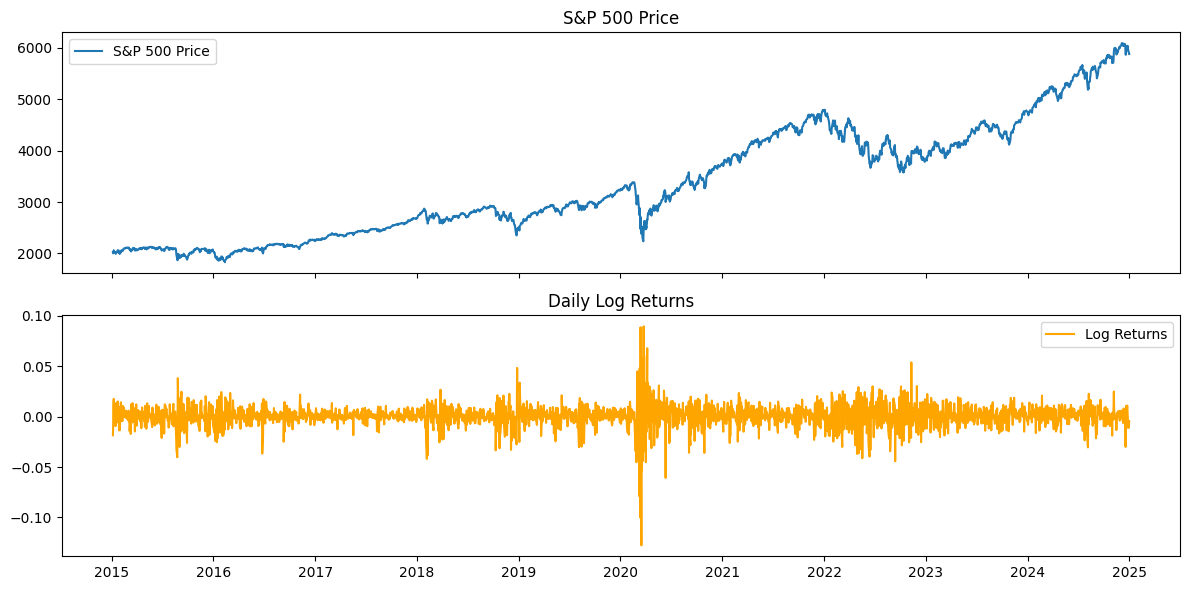

In [3]:
# Plot price and returns 
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
axes[0].plot(data['price'], label='S&P 500 Price')
axes[0].set_title('S&P 500 Price')
axes[0].legend()

axes[1].plot(data['log_return'], color='orange', label='Log Returns')
axes[1].set_title('Daily Log Returns')
axes[1].legend()

plt.tight_layout()
plt.show()

---
## **Exploratory Data Analysis (EDA)**
Before fitting a GARCH model, we examine the volatility characteristics of the S&P 500 returns:
- **Rolling Volatility (30-day)** – to visualize volatility clustering.
- **ACF of Squared Returns** – to statistically test for volatility persistence.

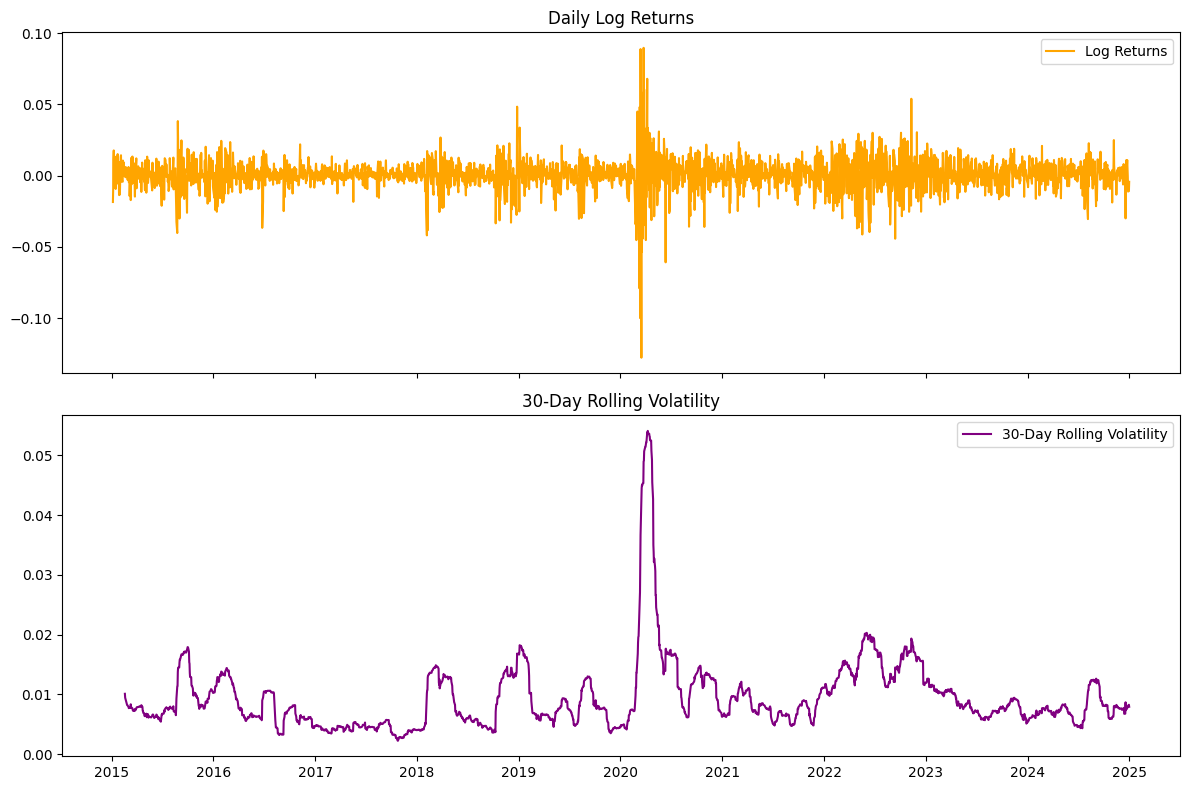

In [4]:
# Calculate 30-day rolling volatility (std of log returns)
data['rolling_volatility'] = data['log_return'].rolling(window=30).std()

# Plot log returns and rolling volatility 
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot daily log returns
ax[0].plot(data['log_return'], color='orange', label='Log Returns')
ax[0].set_title('Daily Log Returns')
ax[0].legend()

# Plot rolling volatility
ax[1].plot(data['rolling_volatility'], color='purple', label='30-Day Rolling Volatility')
ax[1].set_title('30-Day Rolling Volatility')
ax[1].legend()

plt.tight_layout()
plt.show()

There is clear volatility clustering: low-volatility periods (2016-20017) and high-volatility spikes (e.g., early 2020 during COVID-19 crash).

<Figure size 1000x400 with 0 Axes>

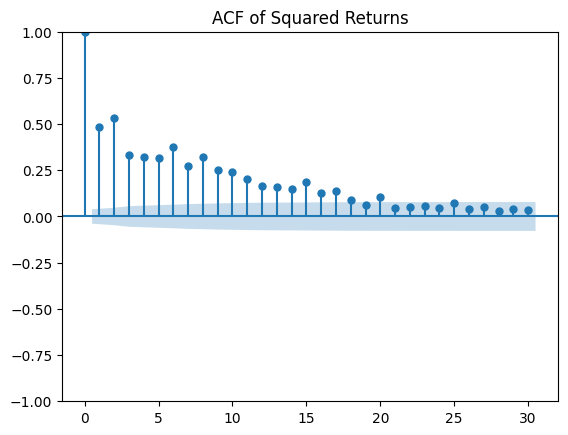

In [5]:
# Plot ACF for squared returns to detect volatility clustering
squared_returns = data['log_return'] ** 2
plt.figure(figsize=(10, 4))
plot_acf(squared_returns, lags=30)
plt.title('ACF of Squared Returns')
plt.show()

The first few lags (1–10 days) have significant autocorrelation (above the blue confidence band). This means volatility is persistent: high volatility today implies high volatility in the next few days.

---
## **GARCH(1, 1) Model Fitting**
We will use the `arch` library to fit a GARCH(1,1) model to the S&P 500 log returns. The model will estimate parameter $\omega, \alpha, \beta$ and produce the conditional volatility $\sigma_t$. 

In [6]:
# Define the model 
# - Mean='Zero': No mean model (just focus on volatility)
# - Vol='GARCH': Use GARCH model
# - p=1, q=1: GARCH(1,1)
model = arch_model(data['log_return'] * 100, mean='Zero', vol='GARCH', p=1, q=1)

# Fit the model
model_fit = model.fit(update_freq=5)
print(model_fit.summary())

Iteration:      5,   Func. Count:     31,   Neg. LLF: 3246.5814317841614
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3246.5624353774547
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9
                       Zero Mean - GARCH Model Results                        
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3246.56
Distribution:                  Normal   AIC:                           6499.12
Method:            Maximum Likelihood   BIC:                           6516.61
                                        No. Observations:                 2515
Date:                Fri, Jul 18 2025   Df Residuals:                     2515
Time:                        06:00:36   Df Model:                            0
        

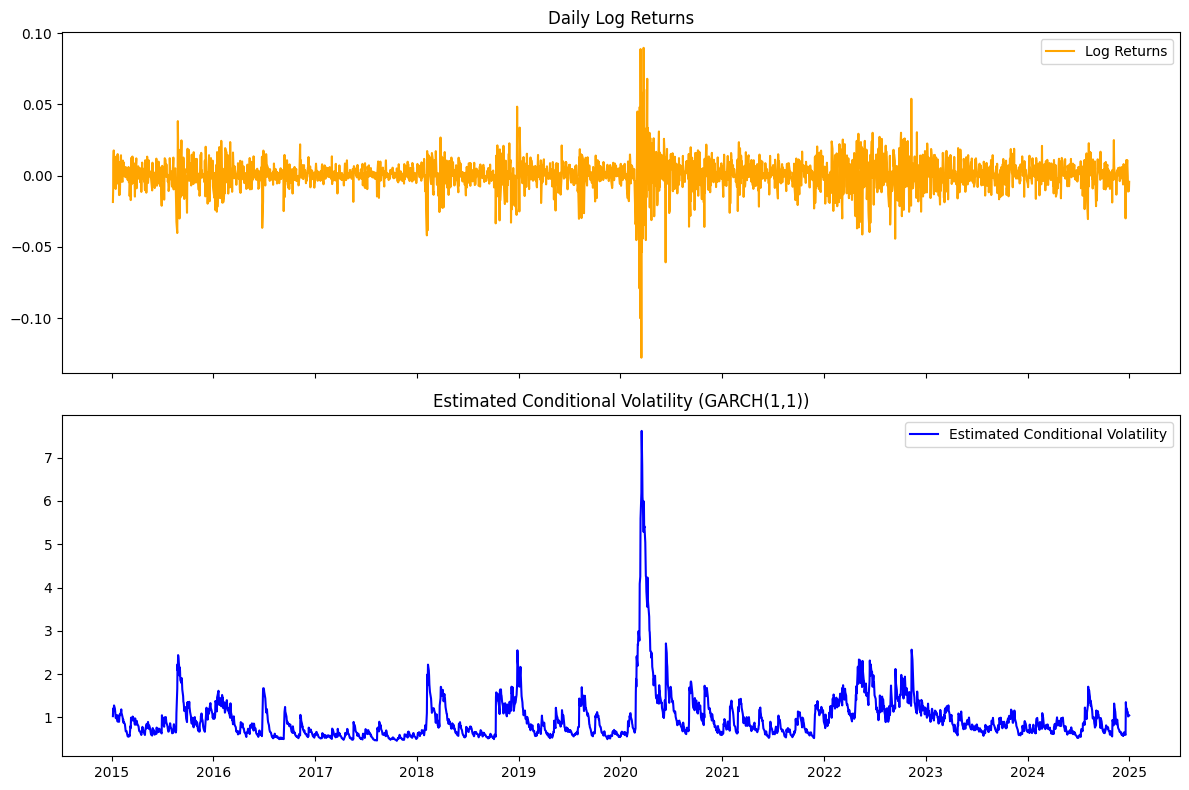

In [7]:
# Extract conditional volatility (σ_t)
data['cond_vol'] = model_fit.conditional_volatility

# Plot log returns vs estimated conditional volatility
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax[0].plot(data['log_return'], color='orange', label='Log Returns')
ax[0].set_title('Daily Log Returns')
ax[0].legend()

ax[1].plot(data['cond_vol'], color='blue', label='Estimated Conditional Volatility')
ax[1].set_title('Estimated Conditional Volatility (GARCH(1,1))')
ax[1].legend()

plt.tight_layout()
plt.show()

The estimated conditional volatility spikes (bottom chart) align perfectly with turbulent periods like 2020 (COVID-19 crash). The volatility level and clustering pattern are consistent with the rolling volatility plot we created earlier.

---

## **Volatility Forecasting**

We will generate:
1. 1-step-ahead volatility forecast (for the next trading day).
2. Multi-step forecasts (e.g., 30 days ahead).
3. A forecast plot showing predicted volatility vs. historical estimates.

In [8]:
# Generate 30-day ahead forecast
forecast_horizon = 30
garch_forecast = model_fit.forecast(horizon=forecast_horizon)

# Extract forecasts
# Last day forecast (1-step ahead)
one_step_vol_forecast = np.sqrt(garch_forecast.variance.values[-1, 0])
print(f"1-Day Ahead Volatility Forecast: {one_step_vol_forecast:.4f}%")

# Multi-step forecast (30 days ahead)
multi_step_vol_forecast = np.sqrt(garch_forecast.variance.values[-1, :])

1-Day Ahead Volatility Forecast: 0.9724%


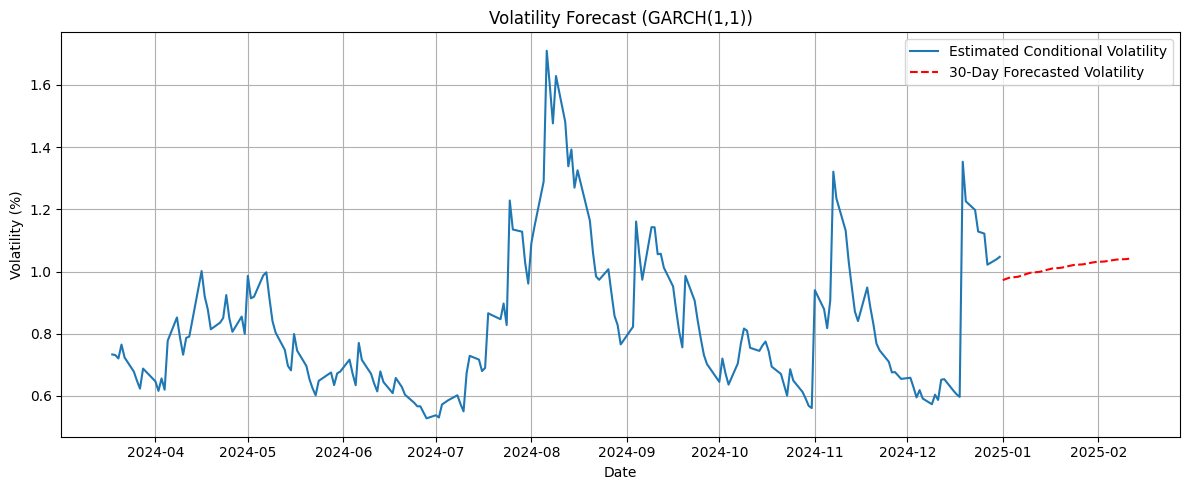

In [9]:
# Step 3: Plot historical and forecasted volatility
plt.figure(figsize=(12, 5))
plt.plot(data['cond_vol'][-200:], label='Estimated Conditional Volatility')
plt.plot(pd.date_range(data.index[-1], periods=forecast_horizon+1, freq='B')[1:], 
         multi_step_vol_forecast, color='red', linestyle='--', label='30-Day Forecasted Volatility')
plt.title('Volatility Forecast (GARCH(1,1))')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

---
## **Model Evaluation Section**
To assess the accuracy of our GARCH(1,1) volatility forecasts, we compare:
- Forecasted conditional volatility (from the model),
- Realized volatility, proxied by squared returns,
- And calculate forecast error metrics.

**Evaluation Metrics**
1. Mean Squared Error (MSE):
    Measures the average squared difference between forecasted and realized volatility.
2. QLIKE Loss (Quasi-Likelihood Loss):
    A robust loss function that penalizes incorrect volatility forecasting. Lower QLIKE = better forecast.

In [10]:
# Align forecast and realized volatility for last N days
N = 100  # evaluation window
true_returns = data['log_return'].iloc[-N:] * 100
realized_vol = true_returns ** 2  # squared returns as realized variance
forecasted_vol = data['cond_vol'].iloc[-N:]  # from GARCH model

# MSE between realized and forecasted volatility
mse = mean_squared_error(realized_vol, forecasted_vol ** 2)

# QLIKE loss
def qlike(y_true, y_pred):
    return np.mean(np.log(y_pred ** 2) + y_true ** 2 / (y_pred ** 2))

qlike_loss = qlike(true_returns, forecasted_vol)

print(f"Model Evaluation (last {N} days):")
print(f"→ MSE: {mse:.6f}")
print(f"→ QLIKE Loss: {qlike_loss:.4f}")

Model Evaluation (last 100 days):
→ MSE: 1.944327
→ QLIKE Loss: 0.7260


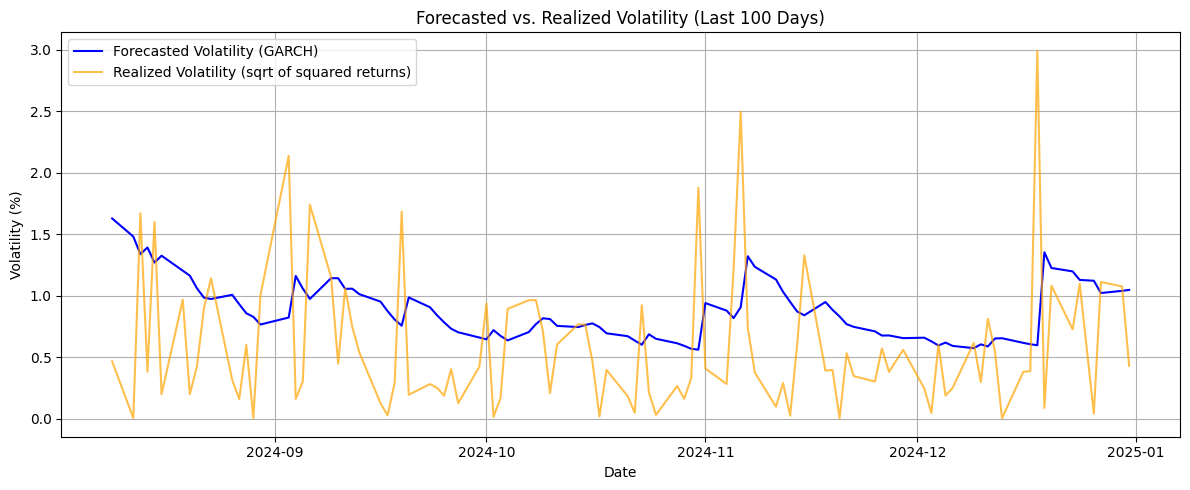

In [11]:
plt.figure(figsize=(12, 5))
plt.plot(forecasted_vol.index, forecasted_vol, label='Forecasted Volatility (GARCH)', color='blue')
plt.plot(realized_vol.index, np.sqrt(realized_vol), label='Realized Volatility (sqrt of squared returns)', color='orange', alpha=0.7)
plt.title(f"Forecasted vs. Realized Volatility (Last {N} Days)")
plt.xlabel("Date")
plt.ylabel("Volatility (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

---
## **Benchmark Models**
We will compare the GARCH(1,1) forecast against: 
1. **Rolling Standard Deviation (30-day window):**
2. **EWMA Volatility (Exponentially Weighted Moving Average):**

In [12]:
# Compute realized volatility (squared returns)
realized_vol = (data['log_return'] * 100) ** 2

# Rolling Standard Deviation (30-day)
rolling_vol = data['log_return'].rolling(window=30).std() * 100

# EWMA Volatility (RiskMetrics style)
lambda_ = 0.94
ewma_vol = []
prev_var = realized_vol.iloc[0]
for r in realized_vol:
    prev_var = lambda_ * prev_var + (1 - lambda_) * r
    ewma_vol.append(np.sqrt(prev_var))
ewma_vol = pd.Series(ewma_vol, index=data.index)

# Align with GARCH forecasted volatility
garch_vol = data['cond_vol']

In [13]:
def evaluate_model(forecast, true):
    mse = mean_squared_error(true, forecast**2)
    qlike_loss = np.mean(np.log(forecast**2) + true / (forecast**2))
    return mse, qlike_loss

N = 250  # Use last 250 trading days (~1 year)
realized_eval = realized_vol[-N:]
garch_eval = garch_vol[-N:]
rolling_eval = rolling_vol[-N:]
ewma_eval = ewma_vol[-N:]

models = ['GARCH(1,1)', 'Rolling Std (30d)', 'EWMA (λ=0.94)']
forecasts = [garch_eval, rolling_eval, ewma_eval]

results = []
for name, forecast in zip(models, forecasts):
    mse, qlike = evaluate_model(forecast, realized_eval)
    results.append({'Model': name, 'MSE': mse, 'QLIKE': qlike})

results_df = pd.DataFrame(results)
print(results_df)

               Model       MSE     QLIKE
0         GARCH(1,1)  1.474596  0.559027
1  Rolling Std (30d)  1.401805  0.474399
2      EWMA (λ=0.94)  1.290615  0.384178


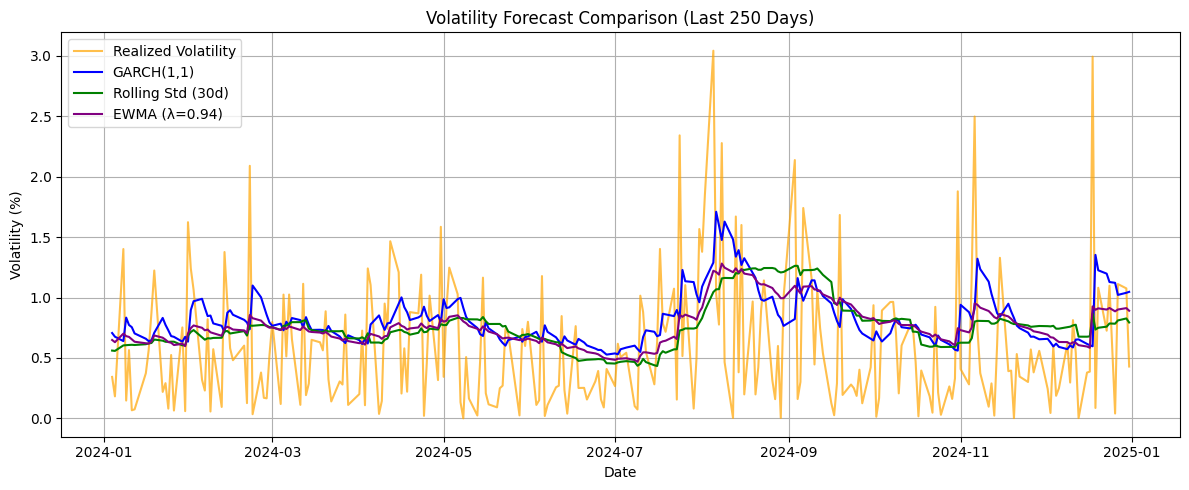

In [14]:
plt.figure(figsize=(12, 5))
plt.plot(realized_eval.index, np.sqrt(realized_eval), label='Realized Volatility', color='orange', alpha=0.7)
plt.plot(garch_eval.index, garch_eval, label='GARCH(1,1)', color='blue')
plt.plot(rolling_eval.index, rolling_eval, label='Rolling Std (30d)', color='green')
plt.plot(ewma_eval.index, ewma_eval, label='EWMA (λ=0.94)', color='purple')
plt.title("Volatility Forecast Comparison (Last 250 Days)")
plt.xlabel("Date")
plt.ylabel("Volatility (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

---
## **Summary & Conclusion**
1. Volatility Clustering Observed: The S&P 500 daily log returns exhibit clear volatility clustering, confirmed by both the rolling volatility plots and ACF of squared returns. This justified the use of a GARCH model.

2. GARCH(1,1) Performance:
   - The fitted GARCH(1,1) model produced reasonable parameters: 
     - $\alpha = 0.168, \beta = 0.799, \alpha+\beta = 0.967 < 1$, confirming mean-reverting volatility.
   - 1-day ahead volatility forecast: ~0.97%, aligning with typical S&P 500 daily volatility.
   - Forecasted volatility captured the general trends and persistent volatility during turbulent periods (e.g., 2020 COVID crash).
3. Benchmark Comparison:
   - Over the last 250 trading days, EWMA (λ = 0.94) outperformed both Rolling Std (30d) and GARCH(1,1):
     - EWMA: MSE = 1.29, QLIKE = 0.38
     - Rolling Std: MSE = 1.40, QLIKE = 0.47
     - GARCH(1,1): MSE = 1.47, QLIKE = 0.56
   - EWMA’s better performance suggests that for short-term forecasting, simpler adaptive models can outperform parametric GARCH.
4. When to Use GARCH: GARCH remains valuable for longer-horizon forecasting, risk management (e.g., Value-at-Risk), and derivative pricing, where a full parametric model of conditional volatility is required.